Two galaxy blends are created and given to WLDEblending package. The Output can then be analyzed with DM stack to study how blending effects depend on the individual galaxy parameters 

## To Do!!
#### Check variance array
#### Add hsm
#### Match centers of dm output to truth
#### Check dm output for undtected objects & spurious detections
#### Add option to run part 1 without dm
#### get heavyfootprint image
#### Add premade catalog of 2 galaxy blend +analysis
#### put part 1 in a function
#### add bounds on second galaxy parameters


In [1]:
import numpy as np
from astropy.table import Table
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import fitsio
import sys
sys.path.insert(0, 'WeakLensingDeblending/')
import descwl
import os
from sklearn.neighbors import KDTree

In [2]:
plt.rc('image', origin='lower',
       interpolation='none')
plt.rc('font', family='sans-serif')
plt.rc('xtick.major', size=4, pad=7)
plt.rc('xtick', labelsize=10)
plt.rc('ytick.major', size=4, pad=7)
plt.rc('ytick', labelsize=10)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=12)
plt.rc('legend',**{'fontsize':12})
plt.rc('savefig', bbox='tight')
plt.rc('figure.subplot', wspace=0.3)
plt.rc('figure.subplot', hspace=0.3)
plt.rc('legend', fancybox=True, borderaxespad=0.)

In [3]:
import scipy.spatial
import scipy.ndimage

In [4]:
import lsst.afw.table
import lsst.afw.image
import lsst.afw.math
import lsst.meas.algorithms
import lsst.meas.base
import lsst.meas.deblender
# import lsst.meas.extensions.shapeHSM
# from lsst.sims.GalSimInterface.wcsUtils import tanSipWcsFromDetector
# from lsst.sims.GalSimInterface import LSSTCameraWrapper
# from lsst.sims.utils import ObservationMetaData
schema = lsst.afw.table.SourceTable.makeMinimalSchema()
config1 = lsst.meas.algorithms.SourceDetectionConfig()
# Tweaks in the configuration to improve detection
#####
#config1.tempLocalBackground.binSize=8
#config1.minPixels=1
#config1.thresholdValue=12
#####
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=config1)
deblend = lsst.meas.deblender.SourceDeblendTask(schema=schema)
config1 = lsst.meas.base.SingleFrameMeasurementConfig()
## HSM is not included in the stack by default. You have to download it and activate it.
#config1.plugins.names.add('ext_shapeHSM_HsmShapeBj')
#config1.plugins.names.add('ext_shapeHSM_HsmShapeLinear')
#config1.plugins.names.add('ext_shapeHSM_HsmShapeKsb')
# config1.plugins.names.add('ext_shapeHSM_HsmShapeRegauss')
#config1.plugins.names.add('ext_shapeHSM_HsmSourceMoments')
# config1.plugins.names.add('ext_shapeHSM_HsmPsfMoments')
measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema, config=config1)
# camera_wrapper = LSSTCameraWrapper()
# obs = ObservationMetaData(pointingRA=0, pointingDec=0,
#                          boundType='circle', boundLength=2.0,
#                          mjd=52000.0, rotSkyPos=0,
#                          bandpassName='i')

In [5]:
def get_hfpt(catalog, masked_image):
    hfpt = []
    for record in catalog:
        fpt = record.getFootprint()
        #fpt.normalize()
        hfpt.append(lsst.afw.detection.makeHeavyFootprint(fpt, masked_image))
    return hfpt
def process(input_path, output_path=None,seed=123):
    LSST_i = descwl.output.Reader(input_path).results # We read the image using descwl's package
    LSST_i.add_noise(noise_seed=seed) # We add noise
    image = lsst.afw.image.ImageF(LSST_i.survey.image.array) # We translate the image to be stack-readable
    # CHECK THIS!!
    variance_array = LSST_i.survey.image.array # We generate a variance array
    variance = lsst.afw.image.ImageF(variance_array) # Generate the variance image
    masked_image = lsst.afw.image.MaskedImageF(image, None, variance) # Generate a masked image, i.e., an image+mask+variance image (with mask=None)
    psf_array = LSST_i.survey.psf_image.array # We read the PSF image from the package
    psf_array = psf_array.astype(np.float64) 
    # psf_new = scipy.ndimage.zoom(psf_array,zoom=43/76.) # We have to rescale to match the stack's size
    psf_new = scipy.ndimage.shift(psf_array, shift=0.5)[16:61,16:61]
    im = lsst.afw.image.ImageD(psf_new) # Convert to stack's format
    fkernel = lsst.afw.math.FixedKernel(im) 
    psf = lsst.meas.algorithms.KernelPsf(fkernel) # Create the kernel in the stack's format
    exposure = lsst.afw.image.ExposureF(masked_image) # Passing the image to the stack
    exposure.setPsf(psf) # Assign the exposure the PSF that we created
    # wcs_in = tanSipWcsFromDetector('R:2,2 S:1,1',camera_wrapper,obs,2000) # We generate a WCS
    # exposure.setWcs(wcs_in) # And assign it to the exposure
    table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table
    detect_result = detect.run(table, exposure) # We run the stack (the detection task)
    catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
    deblend.run(exposure, catalog) # run the deblending task
    measure.run(catalog, exposure) # run the measuring task
    catalog = catalog.copy(deep=True)
    hfpt = get_hfpt(catalog, masked_image)
    if output_path is not None:
        catalog.writeFits(output_path) #write a copy of the catalog
    return catalog, image.array #, hfpt # We return a catalog object

In [6]:
import galsim
import math
def get_a_b(e, hlr):
    """Returns semimajor/minor axis from ellipticity and HLR"""
    q = (1 - e) / (1. + e)
    b = hlr
    a = b / q
    return a, b
def get_g_from_e(e1 ,e2):
    g = np.ones([len(e1),2]) * -10
    for i in range(len(e1)):
        sh = galsim.Shear(e1 = e1[i], e2=e2[i])
        g[i] = [sh.g1, sh.g2]
    return g

def get_biased_g(g, bias):
    return g + bias
def get_ab_sigma(e, sigma):
    q = (1. - e) / (1. + e)
    b = sigma
    a = b / q
    return a, b
def get_p_angle(e):
    p = np.ones(len(e)) * -10
    for i in range(len(e)):
        p[i] = 2 * math.atan2(e[i][1], e[i][0]) 
    return p * 180./np.pi

In [7]:
def display(cat1, cat2, cat3, name, dec=.2):
    if dec is None:
        print ("{0:<19} {1} {2:>40} {3:>26}".format(name, cat1[0], cat2[0], cat3[0]))
    elif (dec == .2):
        print ("{0:<19} {1:.2f}, {2:<12.2f} {3:>26.2f} {4:>26.2f}".format(name, cat1[0], cat1[1], cat2[0], cat3[0]))

def get_sigma(xx,yy,xy):
    """Return defined as |Q|^0.25, where Q is the second momemt"""
    return (xx * yy - xy**2)**0.25



In [8]:
% run make_catalog.py --help


usage: make_catalog.py [-h] [--flux_frac FLUX_FRAC] [--bhlr_frac BHLR_FRAC]
                       [--dhlr_frac DHLR_FRAC] [--x0 X0] [--y0 Y0]
                       [--p_angle P_ANGLE] [--b_e B_E] [--d_e D_E]

optional arguments:
  -h, --help            show this help message and exit
  --flux_frac FLUX_FRAC
                        Flux of second galaxy as a fraction of central galaxy
                        flux [Default:1]
  --bhlr_frac BHLR_FRAC
                        HLR of second galaxy bulge as a fraction of central
                        galaxy bulge HLR [Default:1]
  --dhlr_frac DHLR_FRAC
                        HLR of second galaxy disk as a fraction of central
                        galaxy disk HLR [Default:1]
  --x0 X0               x coordinate of center of second galaxy in pixels.
                        Center of central galaxy is (0,0).[Default:10]
  --y0 Y0               y coordinate of center of second galaxy in pixels.
                        Center of central gal

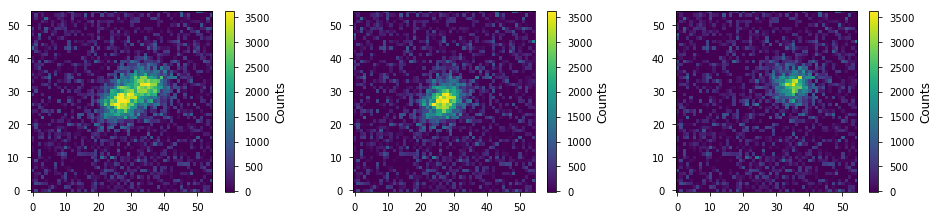

Type                Blend1, Blend2                       Center galaxy only         Second galaxy only

Truth

Flux                354306.22, 265729.66                     354306.22                  265729.66

WLDeblending Pacakage Output

Purity              0.82, 0.72                               1.00                       1.00
SNR_grp             54.40, 41.03                             54.45                      41.07

DM stack output

No of detections    2                                        1                          1
Blendedness         0.33, 0.41                               0.00                       0.00
Flux                291660.93, 287888.67                     327251.57                  250144.19


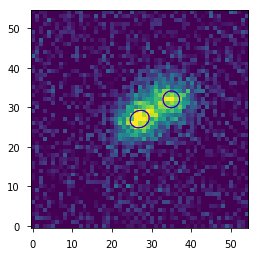

In [15]:
flux_frac = 0.75
bhlr_frac, dhlr_frac = 1, 1
x0, y0= 8, 5
p_angle =0
b_e, d_e = 0., 0.
g1, g2 = 0.01, 0.01

im_h, im_w = 125, 125
band = 'i'
exp = 5520
in_all = 'data/gal_pair_catalog.fits'
out_all = 'data/gal_pair_wldeb.fits'
in1 = 'data/gal1_catalog.fits'
in2 = 'data/gal2_catalog.fits'
out1 = 'data/gal1_wldeb.fits'
out2 = 'data/gal2_wldeb.fits'


% run make_catalog.py --flux_frac $flux_frac --bhlr_frac $bhlr_frac --dhlr_frac $dhlr_frac \
                      --x0 $x0 --y0 $y0 --p_angle $p_angle --b_e $b_e --d_e $d_e

%run WeakLensingDeblending/simulate.py --catalog-name $in_all --output-name $out_all \
    --image-width $im_w --image-height $im_h --no-stamps --filter-band $band --exposure-time $exp \
    --calculate-bias --cosmic-shear-g1 $g1 --cosmic-shear-g2 $g2
%run WeakLensingDeblending/simulate.py --catalog-name $in1 --output-name $out1 \
    --image-width $im_w --image-height $im_h --no-stamps --filter-band $band --exposure-time $exp \
    --calculate-bias --cosmic-shear-g1 $g1 --cosmic-shear-g2 $g2
%run WeakLensingDeblending/simulate.py --catalog-name $in2 --output-name $out2 \
    --image-width $im_w --image-height $im_h --no-stamps --filter-band $band --exposure-time $exp \
    --calculate-bias --cosmic-shear-g1 $g1 --cosmic-shear-g2 $g2

xmin, xmax = 35, 90
ymin, ymax = 35, 90
cat1, im1 = process(out_all, 'data/gal_pair_dm.fits' )
cat2, im2 = process(out1, 'data/gal1_dm.fits' )
cat3, im3 = process(out2, 'data/gal2_dm.fits' )
cat_all = cat1[cat1['deblend_nChild'] ==0]
cat_wl = Table.read(out_all, format='fits')
cat_wl1 = Table.read(out1, format='fits')
cat_wl2 = Table.read(out2, format='fits')
plt.figure(figsize=[16,12])
plt.subplot(3, 3, 1)
plt.imshow(im1[xmin:xmax, xmin:xmax],vmin=-10,vmax=im1.max()*0.8,origin='lower')
plt.colorbar(label='Counts')
plt.subplot(3, 3, 2)
plt.imshow(im2[xmin:xmax, xmin:xmax],vmin=-10,vmax=im1.max()*0.8,origin='lower')
plt.colorbar(label='Counts')
plt.subplot(3, 3, 3)
plt.imshow(im3[xmin:xmax, xmin:xmax],vmin=-10,vmax=im1.max()*0.8,origin='lower')
plt.colorbar(label='Counts')
plt.show()


display(["Blend1, Blend2"], ["Center galaxy only"], ["Second galaxy only"], "Type", dec=None)
print ("\nTruth\n")
display(cat_wl['flux'], cat_wl1['flux'], cat_wl2['flux'], "Flux")
print ("\nWLDeblending Pacakage Output\n")
display(cat_wl['purity'], cat_wl1['purity'], cat_wl2['purity'], "Purity")
display(cat_wl['snr_grp'], cat_wl1['snr_grp'], cat_wl2['snr_grp'], "SNR_grp")
print ('\nDM stack output\n')
display([len(cat_all),], [len(cat2),], [len(cat3),], "No of detections", dec=None)
display(cat_all['base_Blendedness_old'], cat2['base_Blendedness_old'], cat3['base_Blendedness_old'], "Blendedness")
display(cat_all['base_SdssShape_flux'], cat2['base_SdssShape_flux'], cat3['base_SdssShape_flux'], "Flux")


g = get_g_from_e(cat_wl['e1'] ,cat_wl['e2'])
g_new = get_biased_g(g , np.array([0,0]))
g_new_mag = np.hypot(g_new.T[0], g_new.T[1])
a_true, b_true =get_ab_sigma(g_new_mag, 0. +cat_wl['sigma_m'])
p = get_p_angle(g_new)

fig, ax = plt.subplots(1, 1)
ax.imshow(im1[xmin:xmax, xmin:xmax],vmin=-10,vmax=im1.max()*0.8,origin='lower')
e1 = mpatches.Ellipse(((xmax - xmin-1)/2., (ymax - ymin-1)/2.),
                      a_true[0]/0.2, b_true[0]/0.2, p[0] ,
                      edgecolor='red', facecolor='none')
ax.add_patch(e1)
e2 = mpatches.Ellipse(((xmax - xmin-1)/2. + x0, (ymax - ymin-1)/2. + y0),
                      a_true[1]/0.2, b_true[1]/0.2, p[1] ,
                      edgecolor='red', facecolor='none')
ax.add_patch(e2)

g = get_g_from_e(cat_wl['e1'] ,cat_wl['e2'])
g_new = get_biased_g(g , np.array([cat_wl['bias_g1_grp'] ,cat_wl['bias_g2_grp']]))
g_new_mag = np.hypot(g_new.T[0], g_new.T[1])
a_true, b_true =get_ab_sigma(g_new_mag, cat_wl['bias_s_grp']  +cat_wl['sigma_m'])
p = get_p_angle(g_new)

e3 = mpatches.Ellipse(((xmax - xmin-1)/2.+ cat_wl['bias_x_grp'][0], (ymax - ymin-1)/2.+ cat_wl['bias_y_grp'][0]),
                      a_true[0]/0.2, b_true[0]/0.2, p[0] ,
                      edgecolor='blue', facecolor='none')
ax.add_patch(e3)
e4 = mpatches.Ellipse(((xmax - xmin-1)/2. +cat_wl['bias_x_grp'][1] + x0, (ymax - ymin-1)/2. + y0 + cat_wl['bias_y_grp'][1]) ,
                      a_true[1]/0.2, b_true[1]/0.2, p[1] ,
                      edgecolor='blue', facecolor='none')
ax.add_patch(e4)

plt.show()


In [15]:
def get_hfpt(catalog, masked_image):
    hfpt = []
    for record in catalog:
        fpt = record.getFootprint()
        #fpt.normalize()
        hfpt.append(lsst.afw.detection.makeHeavyFootprint(fpt, masked_image))
    return hfpt

In [24]:
lsst.afw.detection.makeHeavyFootprint?

In [11]:
from sklearn.neighbors import KDTree

In [12]:
def match(catalog,truth,wld_cat):
    width,height = wld_cat.survey.image_width,wld_cat.survey.image_height
    X = np.zeros((len(catalog),2))  
    X[:,0] = catalog['base_SdssCentroid_x']
    X[:,1] = catalog['base_SdssCentroid_y']
    X2 = np.zeros((truth.shape[0],2))
    X2[:,0]=truth['dx']/wld_cat.survey.pixel_scale+0.5*width
    X2[:,1]=truth['dy']/wld_cat.survey.pixel_scale+0.5*height
    tree = KDTree(X2,metric='euclidean')
    #Let's try to match to nearest neighbor for now
    dist, ind = tree.query(X,k=1)
    return dist.flatten(),ind.flatten()

dist, ind = match(dm_table,truth_table,wld_cat)
unique_ind, ind_counts = np.unique(ind,return_counts=True)


NameError: name 'dm_table' is not defined

In [ ]:
def get_primary_detection(tru_cat, det_cat,
                          Args, tolerance=5):
    x1, y1 = get_tru_cat_cent(tru_cat, Args)
    z1_tree = spatial.KDTree(zip(x1, y1))
    x2 = det_cat['base_GaussianCentroid_x']
    y2 = det_cat['base_GaussianCentroid_y']
    z2 = zip(x2, y2)
    match = z1_tree.query(z2, distance_upper_bound=tolerance)
    col = Column(np.ones(len(x2)) * -1, 'Primary_Detection',
                 dtype='int')
    det_cat.add_column(col)
    col = Column(np.ones(len(x2)) * -1, 'Primary_Detection_gid',
                 dtype='int')
    det_cat.add_column(col)
    col = Column(np.ones(len(x2)) * -1, 'Prim_Det_Dist')
    det_cat.add_column(col)
    col = Column(np.zeros(len(tru_cat)), 'Detected',
                 dtype='int')
    tru_cat.add_column(col)
    col = Column(np.ones(len(tru_cat)) * -1, 'Primary_Detection',
                 dtype='int')
    tru_cat.add_column(col)
    tru_prim = match[1][~np.isinf(match[0])]
    dist_prim = match[0][~np.isinf(match[0])]
    det_cat['Primary_Detection'][~np.isinf(match[0])] = tru_prim
    det_cat['Primary_Detection_gid'][~np.isinf(match[0])] = tru_cat['grp_id'][tru_prim]
    det_cat['Prim_Det_Dist'][~np.isinf(match[0])] = dist_prim
    tru_cat['Detected'][tru_prim] = 1
    tru_cat['Primary_Detection'][tru_prim] = range(len(det_cat))
    print tru_cat['Primary_Detection']